# Modeling Cross Section Data with Decision Trees

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

# Reading Cross Section Data into Dataframe

In [75]:
print("Reading data into dataframe...")
df = pd.read_csv("working_xs_v1_unsk.csv")
print("Data read into dataframe!")

# Converting specific columns to datatype 'string'
str_cols = ["Target_Meta_State", "MT", "I78", "Refer", "Product_Meta_State", "Frame", "Reaction_Notation", "Title", "Date", "Institute", "Reaction", "Out", "Origin", "Element"]
df[str_cols] = df[str_cols].astype(str)

# Converting remaining columns to numeric type. 
for col in list(df.columns):
    if col not in str_cols:
        df[col] = df[col].astype(float)

# Converting proton, neutron and mass number features to integers
df[["Protons", "Neutrons", "Mass_Number"]] = df[["Protons", "Neutrons", "Mass_Number"]].astype(int)

Reading data into dataframe...
Data read into dataframe!


In [76]:
df.columns

Index(['Target_Meta_State', 'MT', 'Energy', 'dEnergy', 'Data', 'dData',
       'ELV/HL', 'dELV/HL', 'I78', 'Refer', 'Protons', 'Product_Meta_State',
       'Frame', 'Reaction_Notation', 'Title', 'Year', 'Date', 'Institute',
       'Reaction', 'Out', 'Neutrons', 'Origin', 'Mass_Excess', 'dMass_Excess',
       'Binding_Energy', 'dBinding_Energy', 'B_Decay_Energy',
       'dB_Decay_Energy', 'Atomic_Mass_Micro', 'dAtomic_Mass_Micro', 'S(2n)',
       'dS(2n)', 'S(2p)', 'dS(2p)', 'Q(a)', 'dQ(a)', 'Q(2B-)', 'dQ(2B-)',
       'Q(ep)', 'dQ(ep)', 'Q(B-n)', 'dQ(B-n)', 'Mass_Number', 'Element',
       'S(n)', 'dS(n)', 'S(p)', 'dS(p)', 'Q(4B-)', 'dQ(4B-)', 'Q(d,a)',
       'dQ(d,a)', 'Q(p,a)', 'dQ(p,a)', 'Q(n,a)', 'dQ(n,a)', 'Q(g,p)', 'Q(g,n)',
       'Q(g,pn)', 'Q(g,d)', 'Q(g,t)', 'Q(g,He3)', 'Q(g,2p)', 'Q(g,2n)',
       'Q(g,a)', 'Q(p,n)', 'Q(p,2p)', 'Q(p,pn)', 'Q(p,d)', 'Q(p,2n)', 'Q(p,t)',
       'Q(p,3He)', 'Q(n,2p)', 'Q(n,np)', 'Q(n,d)', 'Q(n,2n)', 'Q(n,t)',
       'Q(n,3He)', 'Q(d,t)', 'Q(d,

# Eliminating Non-Numeric and Non-Categorical Features for ML

Some features including the `Reference` and `Reaction Notation` are mostly for information purposes. These need to be removed since models only take numerical and categorical data. 

In [77]:
# Dropping columns not needed for modelling
columns_drop = ["Refer", "Reaction_Notation", "Title", "Date", "Institute", "Reaction", "Out", "Element"]
df = df.drop(columns=columns_drop)

In [78]:
df = df.rename(columns={"Neutrons":"Target_Neutrons", "Mass_Number":"Target_Mass_Number"})
df["Compound_Neutrons"] = df["Target_Neutrons"] + 1
df["Compound_Mass_Number"] = df["Target_Mass_Number"] + 1

In [79]:
df.shape

(4534294, 79)

# One-Hot-Encoding of Categorical Data 

Categorical data can be represented by either assigning a numerical value to each category or by a sparse binary matrix where a `1` is placed when the category is present. We opted for the latter. In this case the categorical features include:

> `Target_Meta_State`: the metastable state of the target particle.

> `MT`: which refers to the ENDF reaction number. 

> `I78`: 

> `Product_Meta_State`: metastable state that the product is left on.

> `Frame`: the established frame of the experiment (center-of-lab or )

> `Origin`: the origin of the measured atomic masses and separation energies.

In [80]:
df.columns

Index(['Target_Meta_State', 'MT', 'Energy', 'dEnergy', 'Data', 'dData',
       'ELV/HL', 'dELV/HL', 'I78', 'Protons', 'Product_Meta_State', 'Frame',
       'Year', 'Target_Neutrons', 'Origin', 'Mass_Excess', 'dMass_Excess',
       'Binding_Energy', 'dBinding_Energy', 'B_Decay_Energy',
       'dB_Decay_Energy', 'Atomic_Mass_Micro', 'dAtomic_Mass_Micro', 'S(2n)',
       'dS(2n)', 'S(2p)', 'dS(2p)', 'Q(a)', 'dQ(a)', 'Q(2B-)', 'dQ(2B-)',
       'Q(ep)', 'dQ(ep)', 'Q(B-n)', 'dQ(B-n)', 'Target_Mass_Number', 'S(n)',
       'dS(n)', 'S(p)', 'dS(p)', 'Q(4B-)', 'dQ(4B-)', 'Q(d,a)', 'dQ(d,a)',
       'Q(p,a)', 'dQ(p,a)', 'Q(n,a)', 'dQ(n,a)', 'Q(g,p)', 'Q(g,n)', 'Q(g,pn)',
       'Q(g,d)', 'Q(g,t)', 'Q(g,He3)', 'Q(g,2p)', 'Q(g,2n)', 'Q(g,a)',
       'Q(p,n)', 'Q(p,2p)', 'Q(p,pn)', 'Q(p,d)', 'Q(p,2n)', 'Q(p,t)',
       'Q(p,3He)', 'Q(n,2p)', 'Q(n,np)', 'Q(n,d)', 'Q(n,2n)', 'Q(n,t)',
       'Q(n,3He)', 'Q(d,t)', 'Q(d,3He)', 'Q(3He,t)', 'Q(3He,a)', 'Q(t,a)',
       'Nuc_Radius_fm', 'Neut_Nuc_Rad_Rati

In [81]:
# Specify categorical variables calculating one-hot-encode features 
cat_cols = ["Target_Meta_State", "MT", "I78", "Product_Meta_State", "Frame", "Origin"]
df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1).drop(columns=cat_cols)

# Corrections for Bad Measurements

Chlorine (n,p) reaction contains contradictory data between two experimental campagins. I am assuming the newest measruments are correct therefore discarding the oldest measruments.

In [82]:
df = df[~((df["Protons"] == 17) & (df["MT_103"] == 1) & (df["Target_Mass_Number"] == 35) & (df["Year"] < 1962))]

In [83]:
df = df.drop(columns=["Year"])

# Sampling Chlorine (n,p) and (n,g) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [84]:
# (n,p) reaction (MT=103)
to_plot = df[(df["Protons"] == 17) & (df["MT_103"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)

# (n,g) reaction (MT=102)
to_plot2 = df[(df["Protons"] == 17) & (df["MT_102"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)

# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [85]:
new_data = pd.read_csv("new_cl_np.csv")  

In [86]:
# Adding features to newly measured data
for i in list(to_plot.columns)[4:]:
    new_data[i] = to_plot[i].values[1]

new_data["Energy"] = np.log10(new_data["Energy"])
new_data["dEnergy"] = np.log10(new_data["dEnergy"])

# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [87]:
endf = pd.read_csv("endf_Cl_np.csv")
endf["Energy"] = np.log10(endf["Energy"])
endf.head()

,Energy,Data
0,6.378527,0.162609
1,6.378917,0.162724
2,6.389669,0.165948
3,6.397940,0.168482
4,6.400994,0.169618


In [88]:
endf_all = pd.read_csv("endf_Cl_np_all.csv")
endf_all["Energy"] = np.log10(endf_all["Energy"])
endf_all.shape

(8791, 2)

# Visualizing Chlroine (n,p) Data

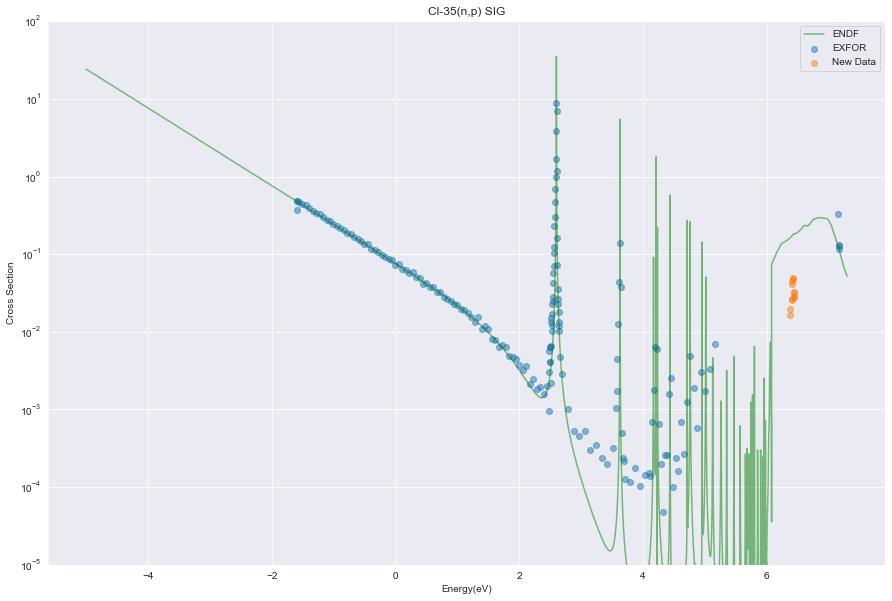

In [89]:
plt.figure(figsize=(15,10))
plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.5, label="EXFOR")
plt.plot(endf_all["Energy"], endf_all["Data"], alpha=0.5, label="ENDF", c="g")
plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data")
plt.title('Cl-35(n,p) SIG')
plt.xlabel('Energy(eV)')
plt.ylabel('Cross Section')
plt.ylim(1E-5, 1E2)
plt.yscale('log')
plt.legend()
plt.show()

# Evaluating Predictions

Two very important measures that are often used in Statistics to determine the accuracy of a model are:

> **R^2 / R-squared**:  also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.

> **Mean Squared Error (MSE)**: measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).
 

In [90]:
from sklearn.metrics import mean_squared_error, r2_score

# Creating Training, Validation, and Testing Datasets

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(["Data", "dData"], axis=1), df["Data"], test_size=0.20, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards features with larger magnitudes.

In [93]:
from sklearn import preprocessing

In [98]:
# Specify columns to scale
to_scale = list(x_train.columns)[:70]
scaler = preprocessing.StandardScaler().fit(x_train[to_scale])
energy_scaler = preprocessing.StandardScaler().fit(x_train[["Energy"]])

In [99]:
x_train[to_scale] = scaler.transform(x_train[to_scale])
x_val[to_scale] = scaler.transform(x_val[to_scale])
x_test[to_scale] = scaler.transform(x_test[to_scale])

# Prediction and Plotting Function

The following functions will be used to easily use the traine model to visualize the results on a particular isotope with a specific reaction type. 

In [100]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    ''' Flexibly plot a univariate distribution of observations. '''
    plt.figure(figsize=(12, 10))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(Title)
    plt.xlabel('Cross Section (b)')
    plt.ylabel('Proportion of Data')
    plt.show()

In [102]:
def predicting_nuclear_xs(MT, Z, M, clf, E_min=0.01, E_max=475000):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_infer = df[(df["Protons"] == Z) & (df[MT] == 1) & (df["Target_Mass_Number"] == M)]
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    
    # Dropping XS data for inference and specifying additional energy range to predict
    # energy_range = np.linspace((1E6*E_min), (E_max*1E6), 200)
    energy_range = np.linspace(np.log10(1E6*E_min), np.log10(E_max*1E6), 50)
    to_infer = to_infer.drop(columns=["Data", "dData"])
    to_infer2 = pd.DataFrame({"Energy": energy_range})
    for i in list(to_infer.columns)[1:]:
        to_infer2[i] = to_infer[i].values[1]
    to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Energy', ascending=True)

    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.transform(to_plot[to_scale])
    new_data[to_scale] = scaler.transform(new_data[to_scale])
    
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat2 = clf.predict(to_plot.drop(columns=["Data", "dData"]))
    y_hat3 = clf.predict(new_data.drop(columns=["Data", "dData"]))
    
    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.inverse_transform(to_plot[to_scale])
    new_data[to_scale] = scaler.inverse_transform(new_data[to_scale])

    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    endf_eval = plt.plot(endf_all["Energy"], endf_all["Data"], alpha=0.3, c="g")
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3, c='b')
    unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.3, c="b")
    
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5, c="orange")
    pred_unseen = plt.scatter(new_data["Energy"], y_hat3, alpha=0.5, c="r")
    
    plt.ylim(1E-5, 1.5E1)
    plt.yscale('log')
    plt.title('Cross Section Inference ' + MT)
    plt.xlabel('Log10 Energy(MeV)')
    plt.ylabel('Cross Section (b)')
    plt.legend((endf_eval, true, unseen, pred, pred_unseen), ('ENDF', 'EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='upper left')
    plt.show()
    
    
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    pred_unseen = plt.scatter(new_data["Energy"], y_hat3, alpha=0.5, c="orange")
    # unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data True", c="r")  
    unseen = plt.errorbar(new_data["Energy"], new_data["Data"], yerr=new_data["dData"], c='b', fmt='o', alpha=0.3)
    endf_data = plt.plot(endf['Energy'], endf["Data"], c="g", alpha=0.3)
#     plt.ylim(1E-5, 1.5E1)
#     plt.yscale('log')
    plt.title('Cross Section Inference ' + MT)
    plt.xlabel('Log10 Energy(MeV)')
    plt.ylabel('Cross Section (b)')
    plt.legend((pred_unseen, unseen, endf_data), ("New Pred", "New", "ENDF"), loc='upper left')
    plt.show()
    
    # Measuring metrics on predictions.
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat2))

In [67]:
# def predicting_nuclear_xs(MT, Z, M, clf, E_min=0.01, E_max=475000):
#     ''' 
#     Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
#     MT is the reaction type (e.g 1 is total cross section)
#     E_min and E_max are the energy region in which to make additional inferences.
#     '''
#     # Extracting dataframe to make predictions
#     # Copying dataframe to apply model metrics 
#     to_infer = df[(df["Protons"] == Z) & (df[MT] == 1) & (df["Mass_Number"] == M)]
#     to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    
#     # Dropping Data (XS) for inference    
#     # Creating additional points to plot based on energy range given
#     # energy_range = np.linspace((1E6*E_min), (E_max*1E6), 200)
#     energy_range = np.linspace(np.log10(1E6*E_min), np.log10(E_max*1E6), 50)
#     to_infer = to_infer.drop(columns=["Data", "dData"])
#     to_infer2 = pd.DataFrame({"Energy": energy_range})
#     for i in list(to_infer.columns)[1:]:
#         to_infer2[i] = to_infer[i].values[1]
#     to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Energy', ascending=True)

#     # Applying standard scaler method 
#     to_infer[to_scale] = scaler.transform(to_infer[to_scale])
#     to_plot[to_scale] = scaler.transform(to_plot[to_scale])
    
        
#     # Making Prediction with given model
#     y_hat  = clf.predict(to_infer)
#     y_hat2 = clf.predict(to_plot.drop(columns=["Data", "dData"]))
    
#     # Returning features to original values for plotting
#     to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
#     to_plot[to_scale] = scaler.inverse_transform(to_plot[to_scale])

#     # Initializing Figure and Plotting 
#     plt.figure(figsize=(12,10))
#     pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5)
#     true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3)
    
#     unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data", c="r")
    
#     plt.ylim(1E-5, 1.5E1)
#     plt.yscale('log')
#     plt.title('Cross Section Inference ' + MT)
#     plt.xlabel('Energy(eV)')
#     plt.ylabel('Cross Section (b)')
#     plt.legend((pred, true, unseen), ('Predicted', 'True', "New"), loc='upper left')
#     plt.show()
    
#     # Measuring metrics on predictions.
#     print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat2))
#     print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat2))

In [101]:
def predicting_nuclear_xs_e(MT, Z, M, clf, E_min=0.01, E_max=475000):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # --- Extracting dataframe to make predictions and
    #     Copying dataframe to apply model metrics 
    to_infer = df[(df["Protons"] == Z) & (df[MT] == 1) & (df["Target_Mass_Number"] == M)][["Energy", "Data"]]
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    
    # Dropping Data (XS) for inference
    # Creating additional points to plot based on energy range given
    energy_range = np.linspace(np.log10(1E6*E_min), np.log10(E_max*1E6), 100)
    to_infer = to_infer.drop(columns=["Data"]).append(pd.DataFrame({"Energy": energy_range}), ignore_index=True).sort_values(by='Energy', ascending=True)

    # Applying standard scaler method 
    to_infer["Energy"] = e_scaler.transform(to_infer[["Energy"]])
    to_plot["Energy"] = e_scaler.transform(to_plot[["Energy"]])
        
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat_2 = clf.predict(to_plot.drop(columns=["Data"]))
    
    # Returning features to original values for plotting
    to_infer[["Energy"]] = e_scaler.inverse_transform(to_infer[["Energy"]])
    to_plot[["Energy"]] = e_scaler.inverse_transform(to_plot[["Energy"]])

    # Initializing Figure and Plotting 
    plt.figure(figsize=(15,10))
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5)
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3)
    
    unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data")
    
    plt.ylim(1E-5, 1.5E1)
    plt.yscale('log')
    plt.title('Cl-35 Cross Section ' + MT)
    plt.xlabel('Energy(eV)')
    plt.ylabel('Cross Section (b)')
    
    plt.legend((pred, true, unseen), ('Predicted', 'True', "New"), loc='upper left')
    
    plt.show()
    
    # Measuring metrics on predictions.
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat_2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat_2))

# Decision Trees

We will try to fit a DT regressor with default parameters. 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [103]:
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [104]:
# Chlorine for Training and Testing (Single Isotope)
x_cl = to_plot.drop(columns=["Data", "dData"])
x_cl[to_scale] = scaler.transform(x_cl[to_scale])
y_cl = to_plot["Data"]
x_cl_train, x_cl_test, y_cl_train, y_cl_test = train_test_split(x_cl, y_cl, test_size=0.20, random_state=0)

# Only Energy
x_cl_en = x_cl[["Energy"]]

In [ ]:
xs_tree = tree.DecisionTreeRegressor(max_depth=150)
xs_tree.fit(x_train, y_train)
print(xs_tree.get_depth())
print("Decision tree model saved to xs_tree!")

xs_val_pred = xs_tree.predict(x_val)
print("MSE: ", mean_squared_error(xs_val_pred, y_val))
print("R2-Score: ", r2_score(xs_val_pred, y_val))

xs_test_pred = xs_tree.predict(x_test)
print("MSE: ", mean_squared_error(xs_test_pred, y_test))
print("R2-Score: ", r2_score(xs_test_pred, y_test))

print(xs_tree.get_depth())

150
Decision tree model saved to xs_tree!
MSE:  100975461958.38504
R2-Score:  0.7758650316268075


In [ ]:
xs_tree.get_depth()

In [ ]:
y_hat = xs_tree.predict(x_cl)

DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, xs_tree, E_min=0.14, E_max=16)

18
Decision tree model saved to xs_tree!


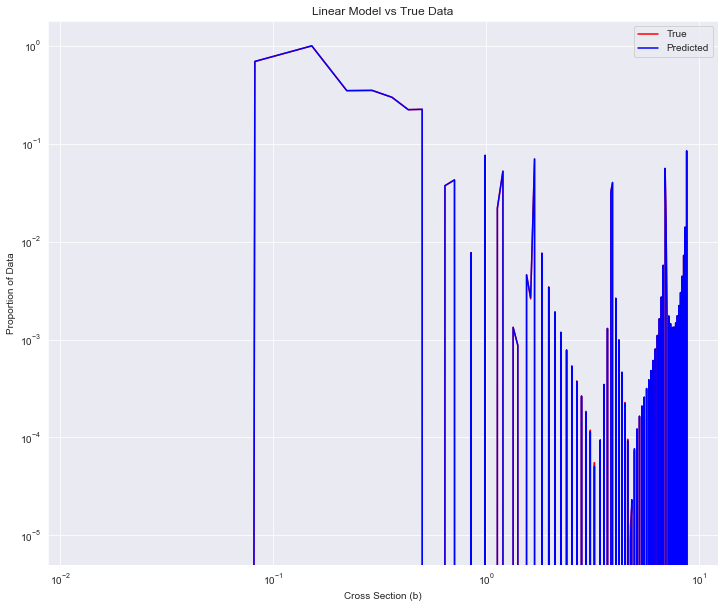

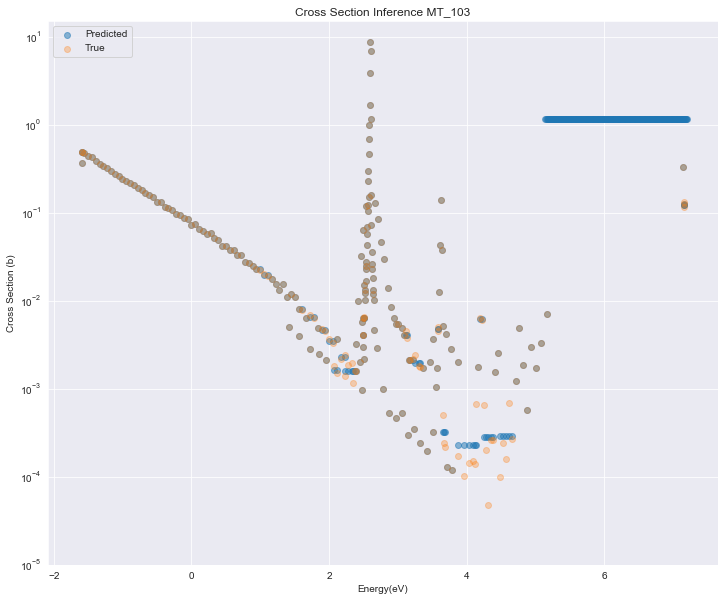

The MSE is:  4.668673080246922e-07
The R2-Score is:  0.9999992892367854


In [26]:
xs_tree = tree.DecisionTreeRegressor(max_depth=100)
xs_tree.fit(x_cl, y_cl)
print(xs_tree.get_depth())
print("Decision tree model saved to xs_tree!")

y_hat = xs_tree.predict(x_cl)
DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, xs_tree, E_min=0.14, E_max=16)

18
Decision tree model saved to xs_tree!


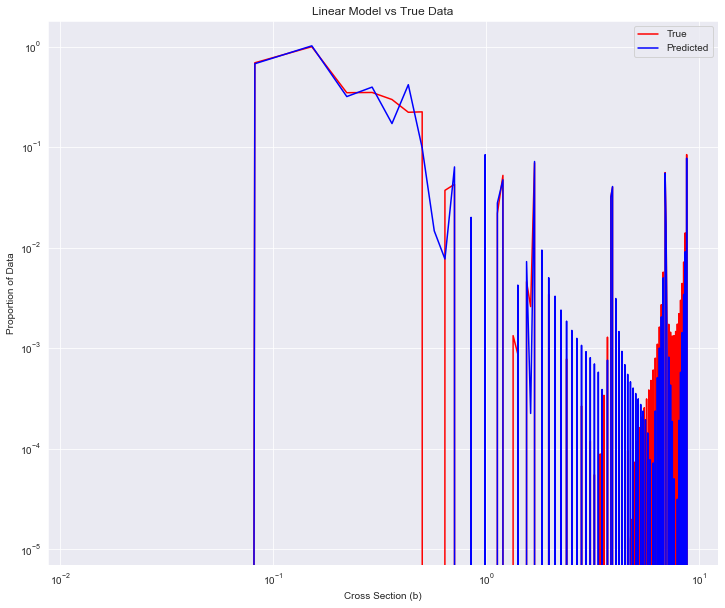

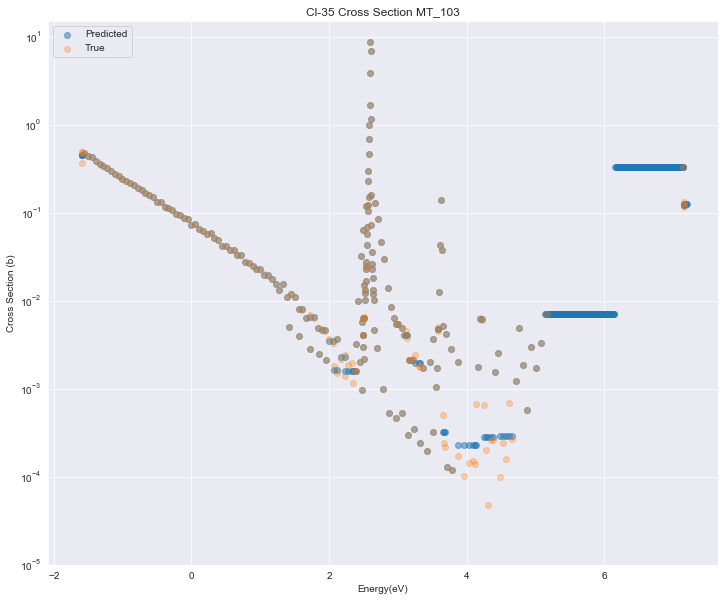

The MSE is:  4.417365743148148e-05
The R2-Score is:  0.9999327496052564


In [28]:
xs_tree = tree.DecisionTreeRegressor(max_depth=100)
xs_tree.fit(x_cl_en, y_cl)
print(xs_tree.get_depth())
print("Decision tree model saved to xs_tree!")

y_hat = xs_tree.predict(x_cl_en)
DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs_e("MT_103", 17, 35, xs_tree, E_min=0.14, E_max=16)

### Making Pipelines

Data Pipelines simplify the steps of processing the data. We use the module Pipeline to create a pipeline. We also use StandardScaler as a step in our pipeline.

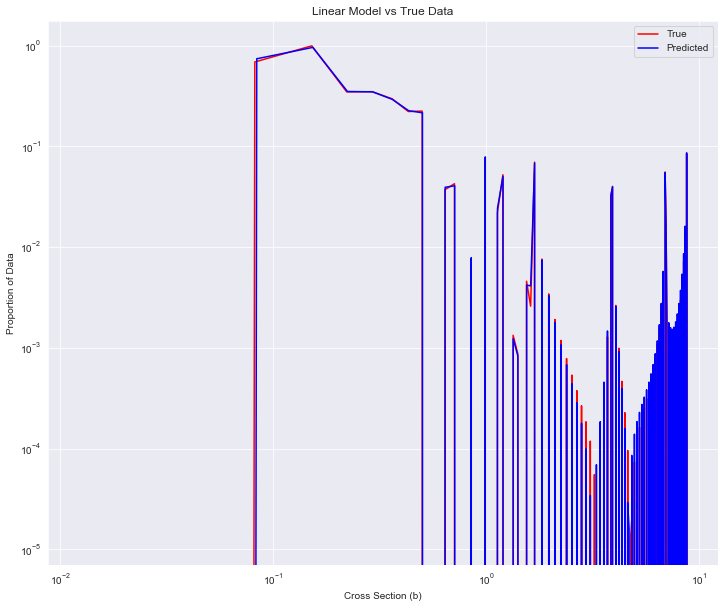

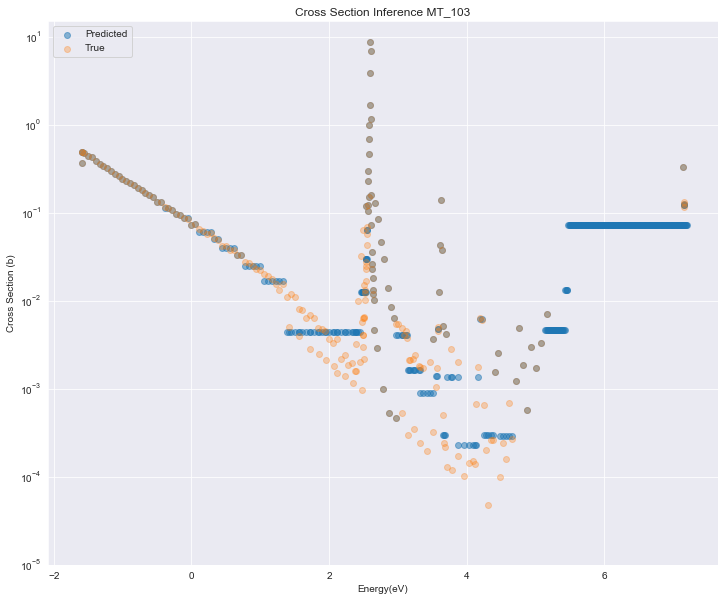

The MSE is:  2.109981249228395e-05
The R2-Score is:  0.9999678774454815


In [29]:
Input = [('polynomial', PolynomialFeatures(include_bias=False, degree=3)), ('model', tree.DecisionTreeRegressor(max_depth=10))]
pipe = Pipeline(Input)
pipe.fit(x_cl, y_cl)
ypipe = pipe.predict(x_cl)

DistributionPlot(y_cl, ypipe, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, pipe, E_min=0.14, E_max=16)

# Grid Search

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
# DT_regressor = tree.DecisionTreeRegressor()
# # parameters = [{"criterion":["mse", "friedman_mse", "mae"], 'max_depth':[10, 50, 100, 120, 150, 180, 1000]}]
# parameters = [{"criterion":["mse", "friedman_mse", "mae"], 'max_depth':[10, 50, 100, 120]}]
# Grid = GridSearchCV(DT_regressor, parameters, cv=4, n_jobs=4, verbose=10)
# Grid.fit(X, y)
# BestRR = Grid1.best_estimator_
# # BestRR.score(x_cl, y_cl)
# # BestRR.score(x_cl, y_test)

In [28]:
DT_regressor = tree.DecisionTreeRegressor()
# parameters = [{"criterion":["mse", "friedman_mse", "mae"], 'max_depth':[10, 50, 100, 120, 150, 180, 1000]}]
parameters1 = [{"criterion":["mse"], 'max_depth':[100, 125, 150, 200]}]
Grid1 = GridSearchCV(DT_regressor, parameters1, cv=2, n_jobs=4, verbose=10)
Grid1.fit(X, y)
BestRR1 = Grid1.best_estimator_

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   8 | elapsed:  2.2min remaining:  6.6min
[Parallel(n_jobs=4)]: Done   3 out of   8 | elapsed:  2.5min remaining:  4.2min
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=4)]: Done   5 out of   8 | elapsed:  4.3min remaining:  2.6min
[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed:  4.6min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  4.8min finished


In [33]:
BestRR1.get_params()

{'criterion': 'mse',
 'max_depth': 200,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

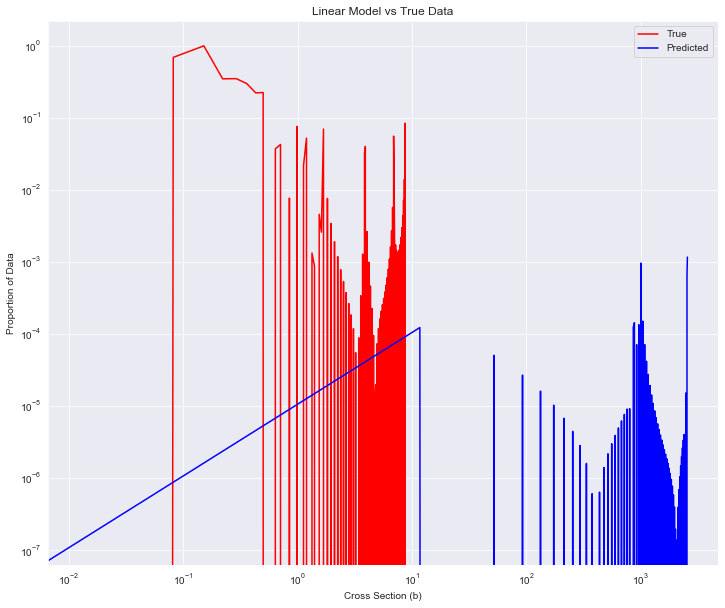

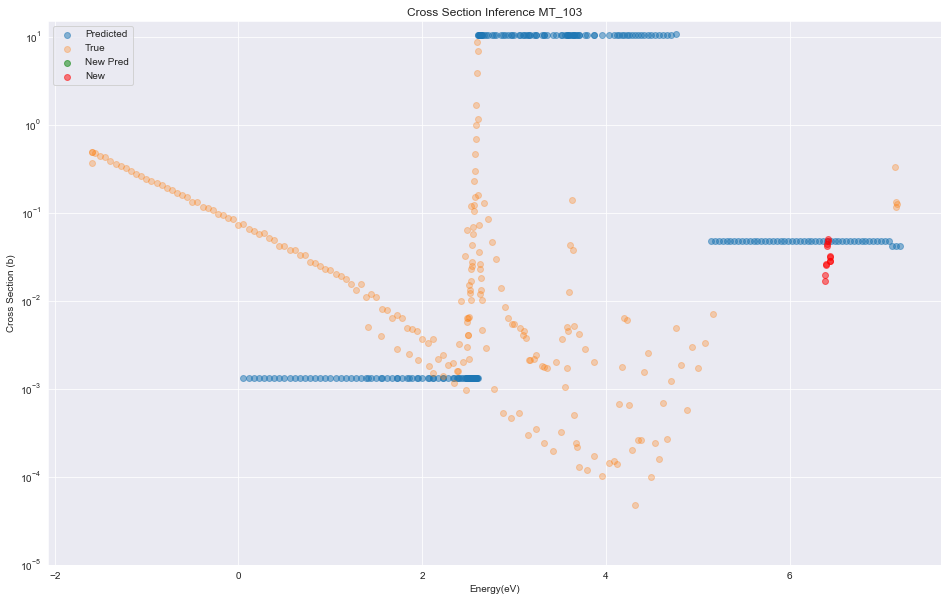

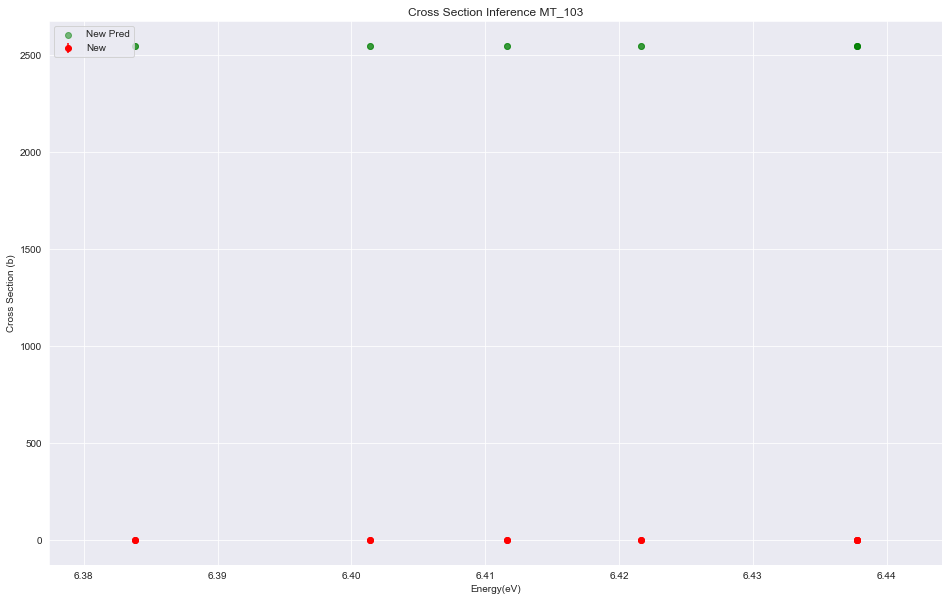

The MSE is:  227906.00441831665
The R2-Score is:  -346965.26117864694


In [31]:
y_hat= BestRR1.predict(x_cl)

DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, BestRR1, E_min=0.14, E_max=16)

In [34]:
parameters2 = [{"criterion":["friedman_mse"], 'max_depth':[100, 125, 150, 200]}]
Grid2 = GridSearchCV(DT_regressor, parameters2, cv=2, n_jobs=4, verbose=10)
Grid2.fit(X, y)
BestRR2 = Grid1.best_estimator_

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   8 | elapsed:  2.1min remaining:  6.4min
[Parallel(n_jobs=4)]: Done   3 out of   8 | elapsed:  2.5min remaining:  4.1min
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=4)]: Done   5 out of   8 | elapsed:  4.2min remaining:  2.5min
[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed:  4.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  4.8min finished


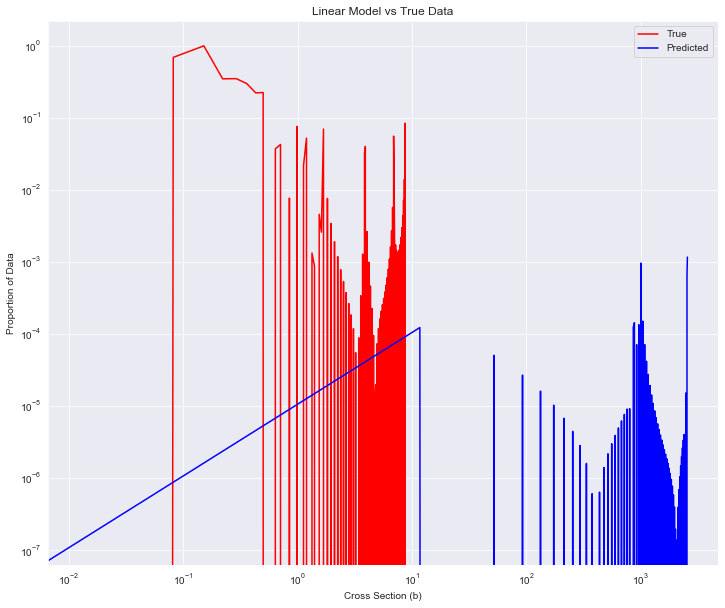

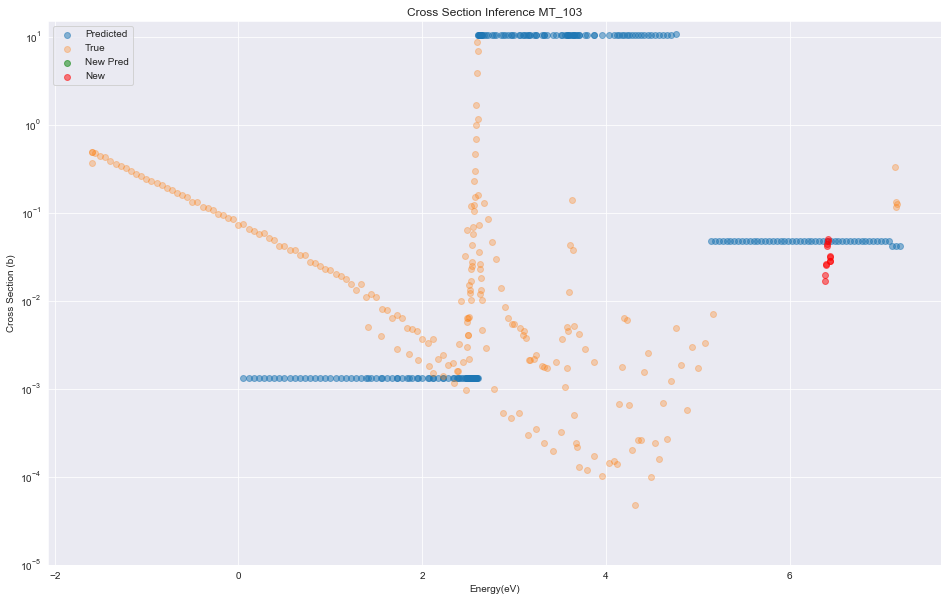

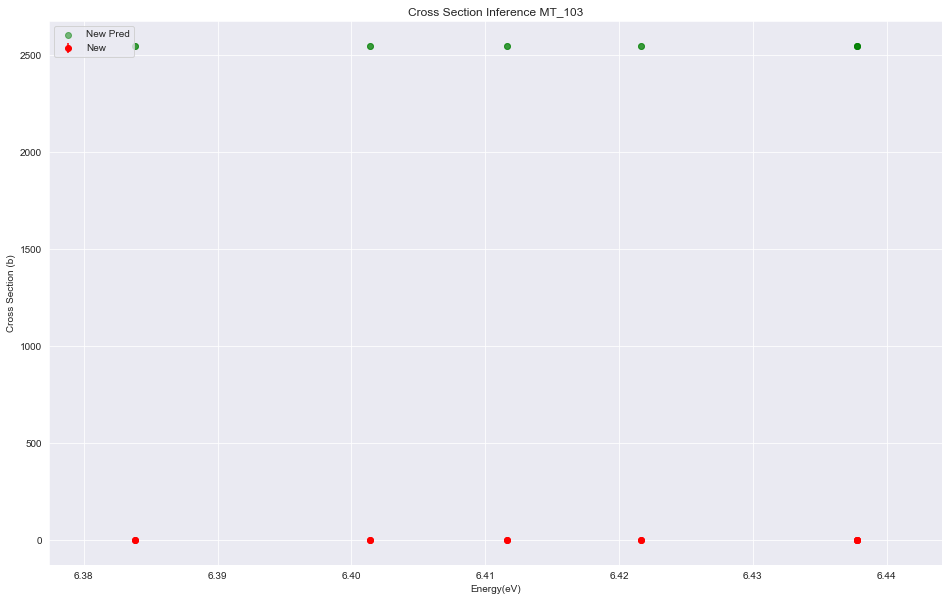

The MSE is:  227906.00441831665
The R2-Score is:  -346965.26117864694


In [35]:
y_hat2 = BestRR2.predict(x_cl)

DistributionPlot(y_cl, y_hat2, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, BestRR2, E_min=0.14, E_max=16)

In [ ]:
parameters3 = [{"criterion":["mae"], 'max_depth':[100, 125, 150, 200]}]
Grid3 = GridSearchCV(DT_regressor, parameters3, cv=2, n_jobs=5, verbose=10)
Grid3.fit(X, y)
BestRR3 = Grid3.best_estimator_

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [ ]:
y_hat3 = BestRR3.predict(x_cl)

DistributionPlot(y_cl, y_hat3, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, BestRR3, E_min=0.14, E_max=16)

In [ ]:
import pickle

# save the model to disk
filename = 'dt_Xs.sav'
pickle.dump(BestRR, open(filename, 'wb'))

In [93]:
pd.DataFrame(Grid2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002499,4.969928e-04,0.001000,6.194296e-07,0.001,True,"{'alpha': 0.001, 'normalize': True}",-0.010030,-134.880968,-0.075444,-3.185245e+06,-796345.046730,1.379232e+06,18
1,0.002250,4.327749e-04,0.001000,4.256623e-07,0.001,False,"{'alpha': 0.001, 'normalize': False}",-0.009750,-134.907443,-0.075421,-1.340535e+01,-37.099492,5.673235e+01,12
2,0.002751,4.327751e-04,0.001250,4.334632e-04,0.1,True,"{'alpha': 0.1, 'normalize': True}",-0.010400,-135.032697,-0.075274,-2.678309e+06,-669611.032235,1.159722e+06,17
3,0.002500,5.001426e-04,0.001000,1.192093e-07,0.1,False,"{'alpha': 0.1, 'normalize': False}",-0.010309,-134.824637,-0.074910,-1.341031e+01,-37.080043,5.669613e+01,11
4,0.002500,5.000830e-04,0.001001,5.057622e-07,1,True,"{'alpha': 1, 'normalize': True}",-0.010610,-134.686592,-0.074895,-8.970619e+05,-224299.164190,3.884197e+05,16
5,0.002250,4.331880e-04,0.001000,3.908538e-07,1,False,"{'alpha': 1, 'normalize': False}",-0.009966,-133.766131,-0.074515,-1.341092e+01,-36.815383,5.623999e+01,3
6,0.002505,5.050741e-04,0.000995,8.570435e-06,10,True,"{'alpha': 10, 'normalize': True}",-0.010246,-133.835502,-0.074403,-3.993986e+04,-10018.444116,1.727522e+04,15
7,0.002000,3.526258e-07,0.001001,1.192093e-07,10,False,"{'alpha': 10, 'normalize': False}",-0.009822,-133.436851,-0.074366,-1.341629e+01,-36.734332,5.609757e+01,1
8,0.002501,4.997254e-04,0.001000,3.576279e-07,100,True,"{'alpha': 100, 'normalize': True}",-0.009929,-134.112661,-0.073972,-5.669257e+02,-175.280559,2.326466e+02,14
9,0.002260,4.284913e-04,0.000991,1.617956e-05,100,False,"{'alpha': 100, 'normalize': False}",-0.009804,-133.722486,-0.074162,-1.345230e+01,-36.814688,5.621696e+01,2
